<div class="admonition abstract">
<p class="admonition-title">Requirements</p>
    <ul>
        <li>python>=3.11</li>
        <li>pandas==2.3.0</li>
        <li>seaborn==0.13.2</li>
        <li>matplotlib==3.10.3</li>
        <li>numpy==2.3.1</li>
        <li>scipy==1.16.0</li>
    </ul>
</div>

<div class="admonition input">
    <p class="admonition-title">Input data</p>
    <ul>
     <li><a href=https://github.com/KTest-VN/lps_paper/tree/main/evaluation/downstream/data/process_prs_scores> Percentile PRS scores</a></li>
     </ul>
</div>

In [1]:
## Import Python packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
## Input variables
raw_prs_scores = '../../../evaluation/downstream/data/process_prs_scores'

output_figs_folder = '../../../evaluation/downstream/out_figs/prs_ADPR'
output_table_folder = '../../../evaluation/downstream/out_tables/prs_percentile'

In [3]:

def process_prs_scores(cutoff = 'Pt_5e-08'):
    """
    Load and process polygenic risk score (PRS) data from a CSV file.

    Parameters:
    ----------
    cutoff : str, optional
        String indicating the p-value threshold or cutoff used in PRS calculation. 
        This is used to construct the file path (default is 'Pt_5e-08').

    Returns:
    -------
    pd.DataFrame
        A DataFrame where:
        - 'array' names are harmonized to consistent display names.
        - A new column 'type' is added indicating whether each entry is from a genotyping 'array' or 'lowpass' sequencing.
    """
    file_path = f'{raw_prs_scores}/{cutoff}.csv'
    data = pd.read_csv(file_path)
    data.replace({'array': {
        'Axiom_PMRAX': 'PMRA',
        'Axiom_JAPONICAX': 'JAPONICA',
        'infinium-omni2.5.v1.5X': 'OMNI2.5',
        'cytosnp-850k-v1.2X': 'CYTOSNP',
        'global-screening-array-v.3X': 'GSA',
        'infinium-omni5-v1.2X': 'OMNI5',
        'Axiom_PMDAX': 'PMDA',
        'Axiom_UKB_WCSGX': 'UKB_WCSG',
        'LPS0.5X': 'LPS_0.5',
        'LPS0.75X': 'LPS_0.75',
        'LPS1.0X': 'LPS_1.0',
        'LPS1.25X': 'LPS_1.25',
        'LPS1.5X': 'LPS_1.5',
        'LPS2.0X': 'LPS_2.0',
    }}, inplace=True)
    data['type'] = ['lowpass' if 'LPS' in i else 'array' for i in data['array']]
    return data

In [4]:
def do_filter_data(data, trait, pop):
    """
    Filter PRS data for a specific trait and population.

    Parameters:
    ----------
    data : pd.DataFrame
        Processed PRS score DataFrame (e.g., output from `process_prs_scores`).
    trait : str
        Trait name to filter by (e.g., 'BMI', 'HEIGHT').
    pop : str
        Population identifier to filter by (e.g., 'EUR', 'EAS').
    """
    pick = (data['trait'] == trait) & (data['pop'] == pop)
    return data[pick]

In [5]:
desired_order = ['GSA', 
                'JAPONICA',
                'UKB_WCSG',
                'CYTOSNP', 
                'PMRA', 
                'PMDA',
                'OMNI2.5', 
                'OMNI5',
                'LPS_0.5',
                'LPS_0.75',
                'LPS_1.0',
                'LPS_1.25',
                'LPS_1.5',
                'LPS_2.0'] 

In [6]:
def plot_1(data, trait, pop, axe):
    """
    Generate a horizontal boxplot of percent difference in PRS performance 
    for a specific trait and population.

    Parameters:
    ----------
    data : pd.DataFrame
        DataFrame containing PRS percent difference ('pct_dif') and metadata 
        including 'array', 'type', 'trait', and 'pop'.
    trait : str
        Trait name to filter and plot (e.g., 'BMI', 'HEIGHT').
    pop : str
        Population identifier to filter and plot (e.g., 'EUR', 'AFR').
    axe : matplotlib.axes.Axes
        Matplotlib axes object on which the plot is drawn.
    """
    filterd_data = do_filter_data(data, trait, pop)
    sns.boxplot(data=filterd_data, 
                y = 'array', 
                x = 'pct_dif', 
                hue='type', fill=False,
                width=0.4,
                order=desired_order,
                fliersize= 0.5,
                orient='h',
                ax=axe)
    threshold = filterd_data[filterd_data['array'] == 'GSA']['pct_dif'].median()
    axe.axvline(threshold, 0, 10, c='r', linestyle ="--", linewidth = 1)
                
    # Grid
    axe.grid(axis='both', linewidth=0.5)

    # Turn off Legend
    axe.legend().set_visible(False)

In [7]:
def full_plot(cutoff):
    """
    Generate a grid of boxplots showing percent difference in PRS performance
    across traits and populations, for a given PRS p-value cutoff.

    Parameters:
    ----------
    cutoff : str
        P-value threshold string used to locate the corresponding PRS data file
        (e.g., 'Pt_5e-08'). The file is expected at `{raw_prs_scores}/{cutoff}.csv`.

    """
    
    data = process_prs_scores(cutoff)
    cols = data['trait'].unique()
    rows = data['pop'].unique()
    fig, axes = plt.subplots(nrows= len(rows) , ncols =  len(cols), figsize=(11,13))

    for i, x in enumerate(rows):
        for j, y in enumerate(cols):
            plot_1(data, y, x, axes[i,j])
            
            # Ticks
            axes[i,j].set_xlim(0, 30.1)
            axes[i,j].set_xticks(np.arange(0, 30.1, 5))
            axes[i,j].set_ylabel("")
            axes[i,j].set_xlabel("")
                
            if i == 0:
                # Title
                axes[i,j].set_title(label=y, 
                            color='white', 
                            bbox=dict(facecolor='#b3b3b3', edgecolor='white', boxstyle='round,pad=0.6'), 
                            x=0.5, pad=12,
                            fontdict={'fontsize':10})
            if j == 0:
                axes[i,j].set_ylabel(ylabel=x,
                                                color='white',
                                                labelpad = 12,
                                                rotation = 'horizontal', 
                                                bbox=dict(facecolor='#b3b3b3', 
                                                          edgecolor='white', 
                                                          boxstyle='round,pad=0.6'),
                                                fontdict={'fontsize':10})
    
    for line_num, line_axis in enumerate(axes):
        for col_num, ax in enumerate(line_axis):
            if col_num == 0:
                continue
            ax.set_ylim(line_axis[0].get_ylim()) # align axes
            plt.setp(ax.get_yticklabels(), visible=False)
            
            
    fig.tight_layout(rect=[0.02, 0.02, 1, 1])
    plt.savefig(f'{output_figs_folder}/{cutoff}.pdf', dpi=300)
    return data
    

In [8]:
all_cutoffs = ["Pt_5e-08", "Pt_1e-07", "Pt_1e-06", "Pt_1e-05", "Pt_0.0001", "Pt_0.001", "Pt_0.01", "Pt_0.1", "Pt_0.2", "Pt_0.3", "Pt_0.5", "Pt_1"]

plotting Pt_5e-08
plotting Pt_1e-07
plotting Pt_1e-06
plotting Pt_1e-05
plotting Pt_0.0001
plotting Pt_0.001
plotting Pt_0.01
plotting Pt_0.1
plotting Pt_0.2
plotting Pt_0.3
plotting Pt_0.5
plotting Pt_1


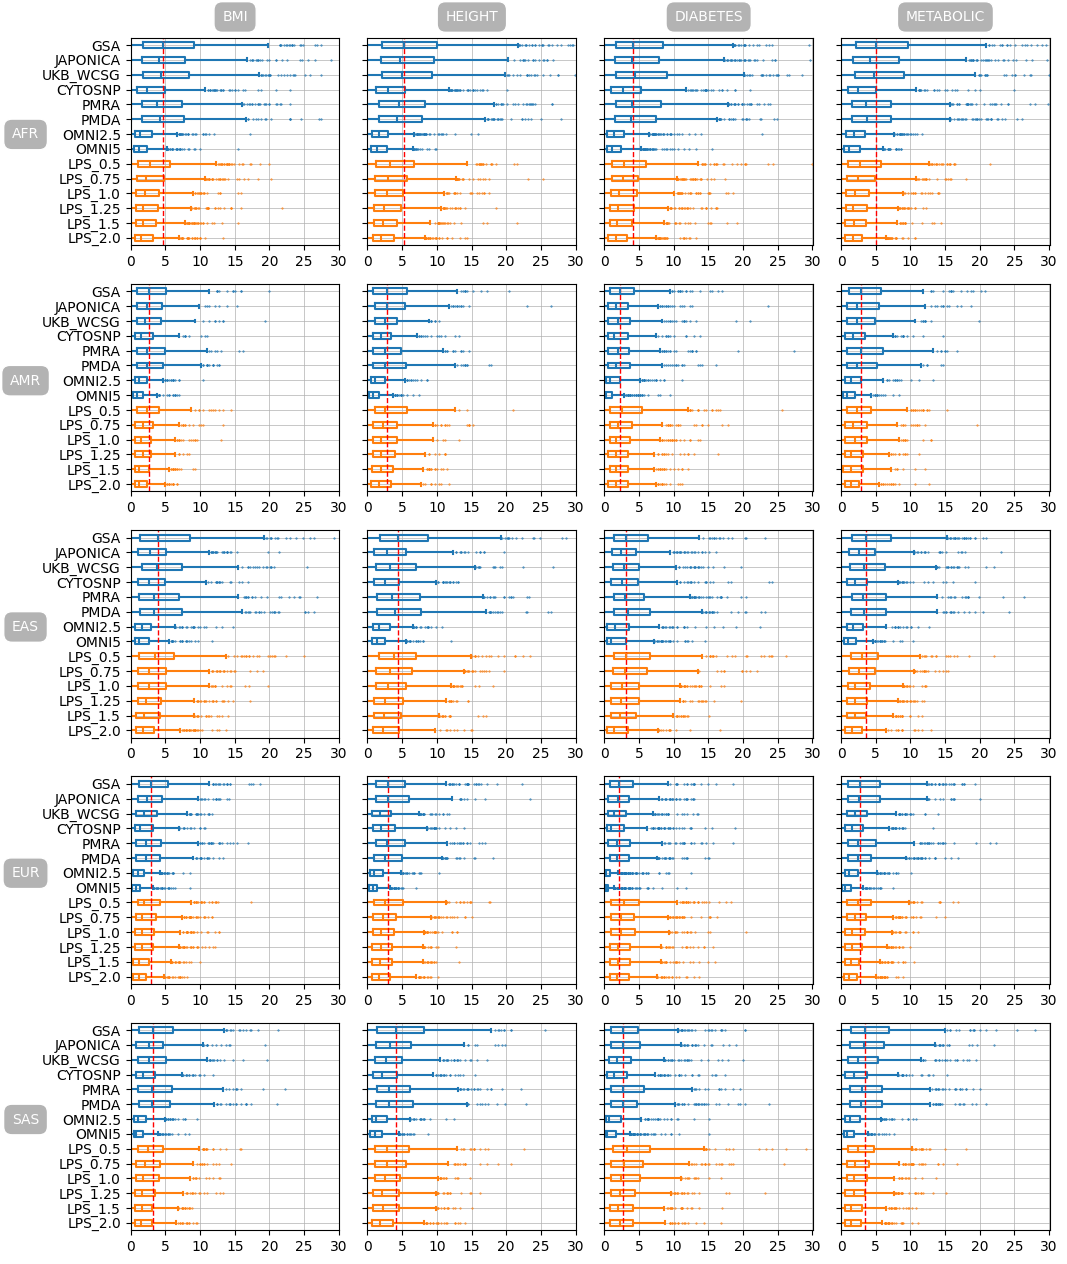

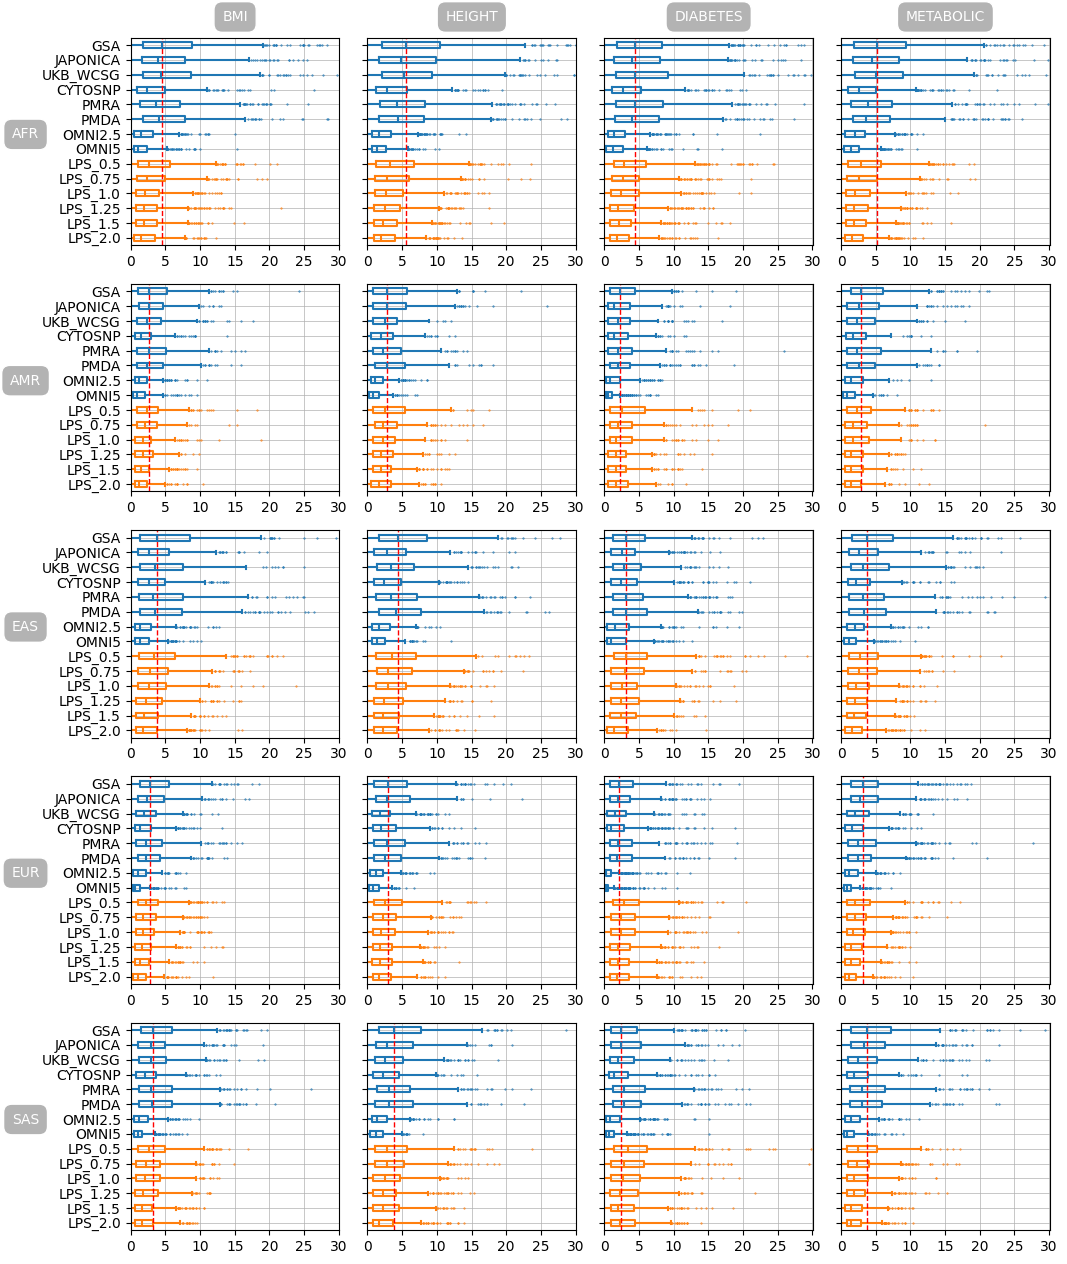

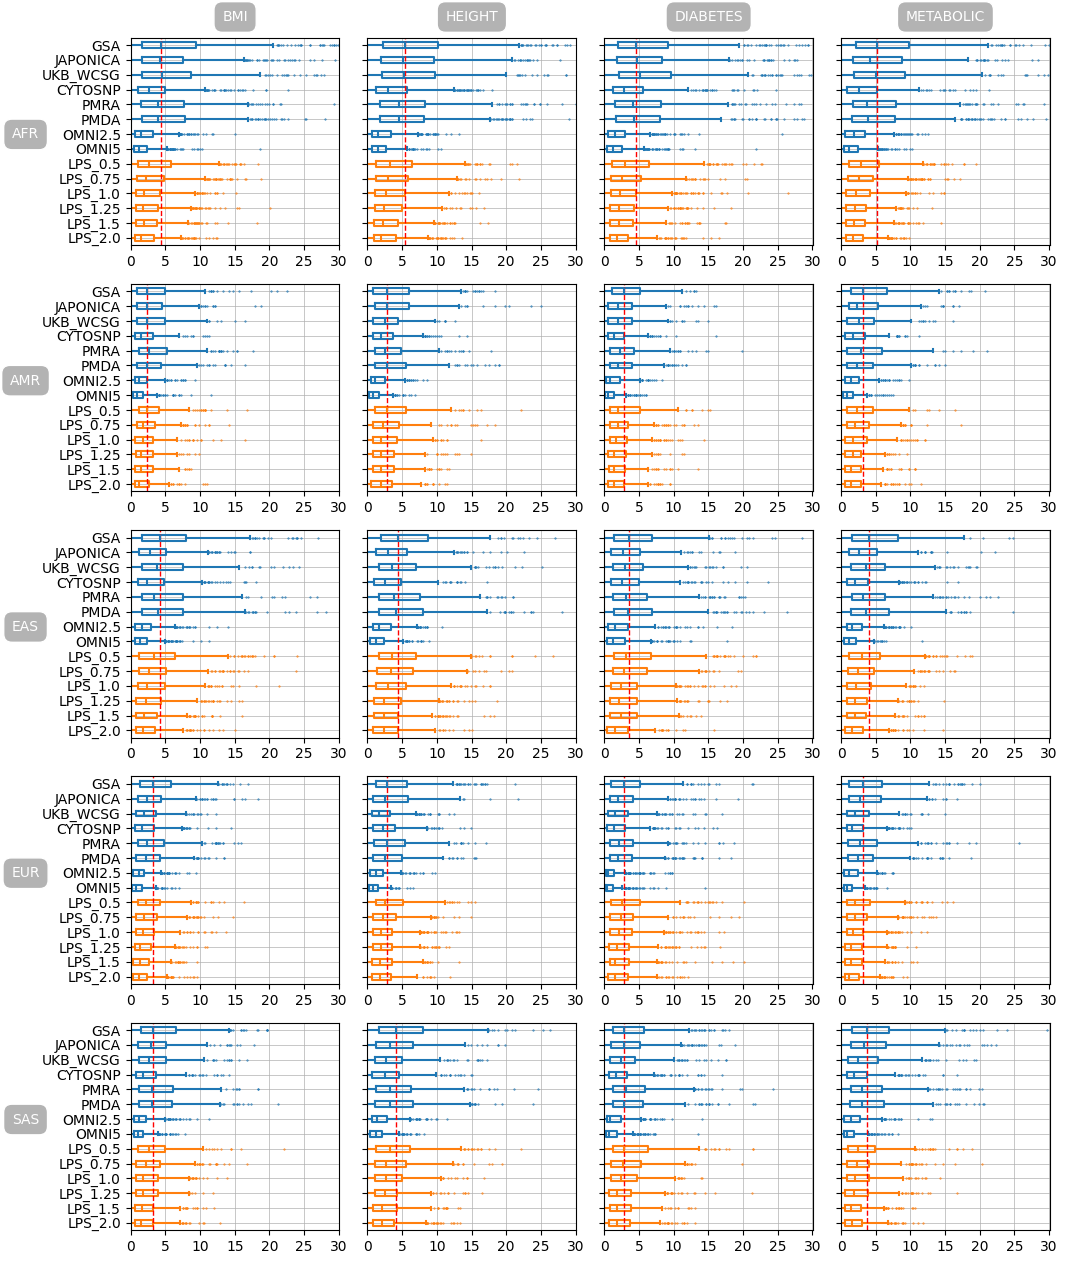

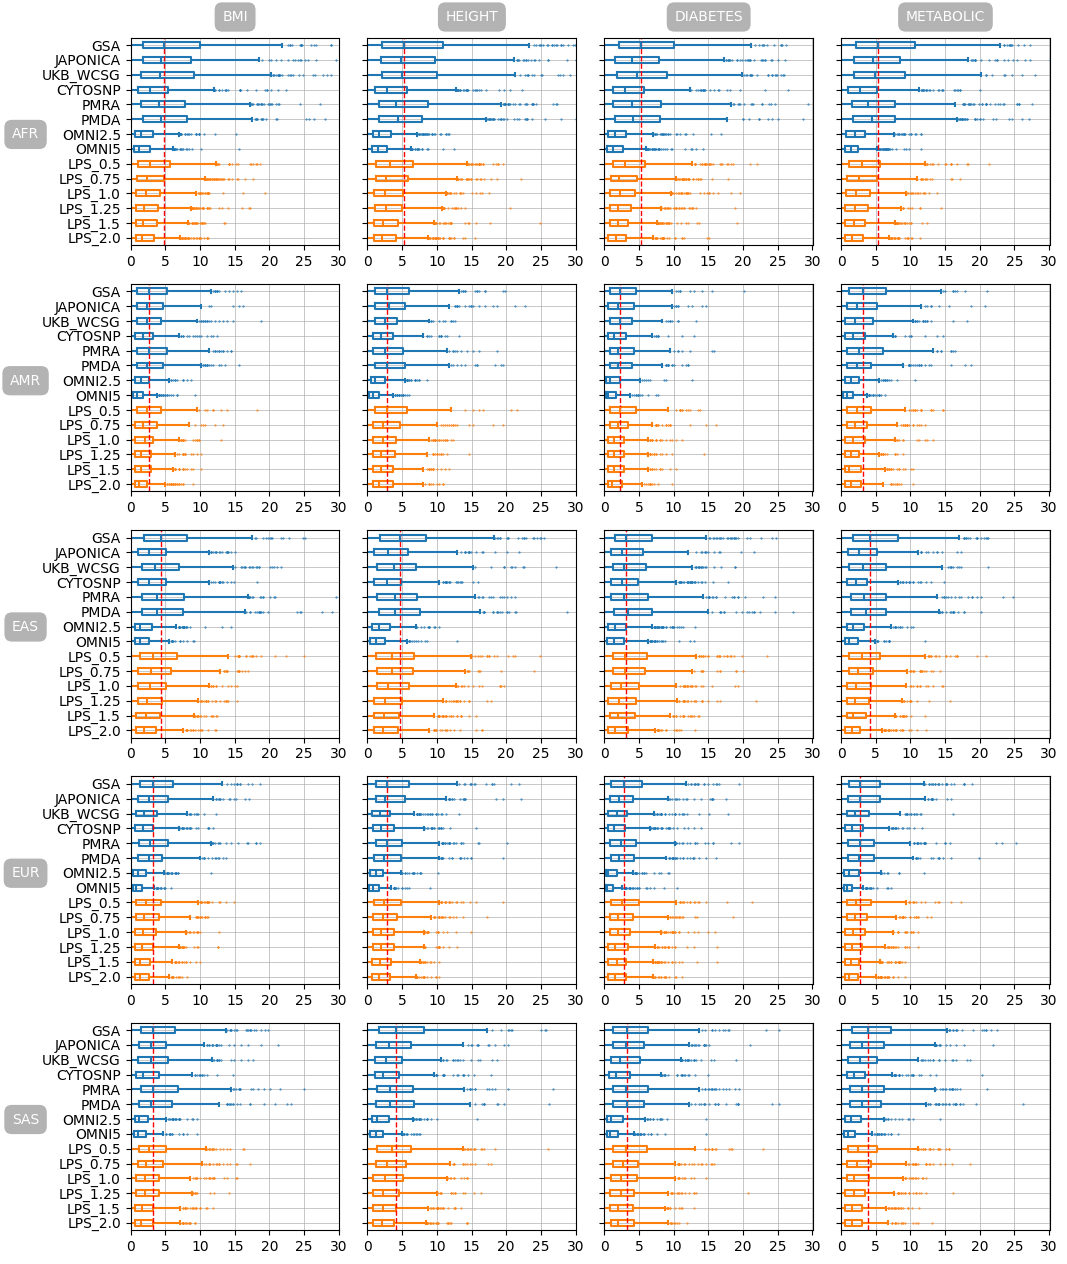

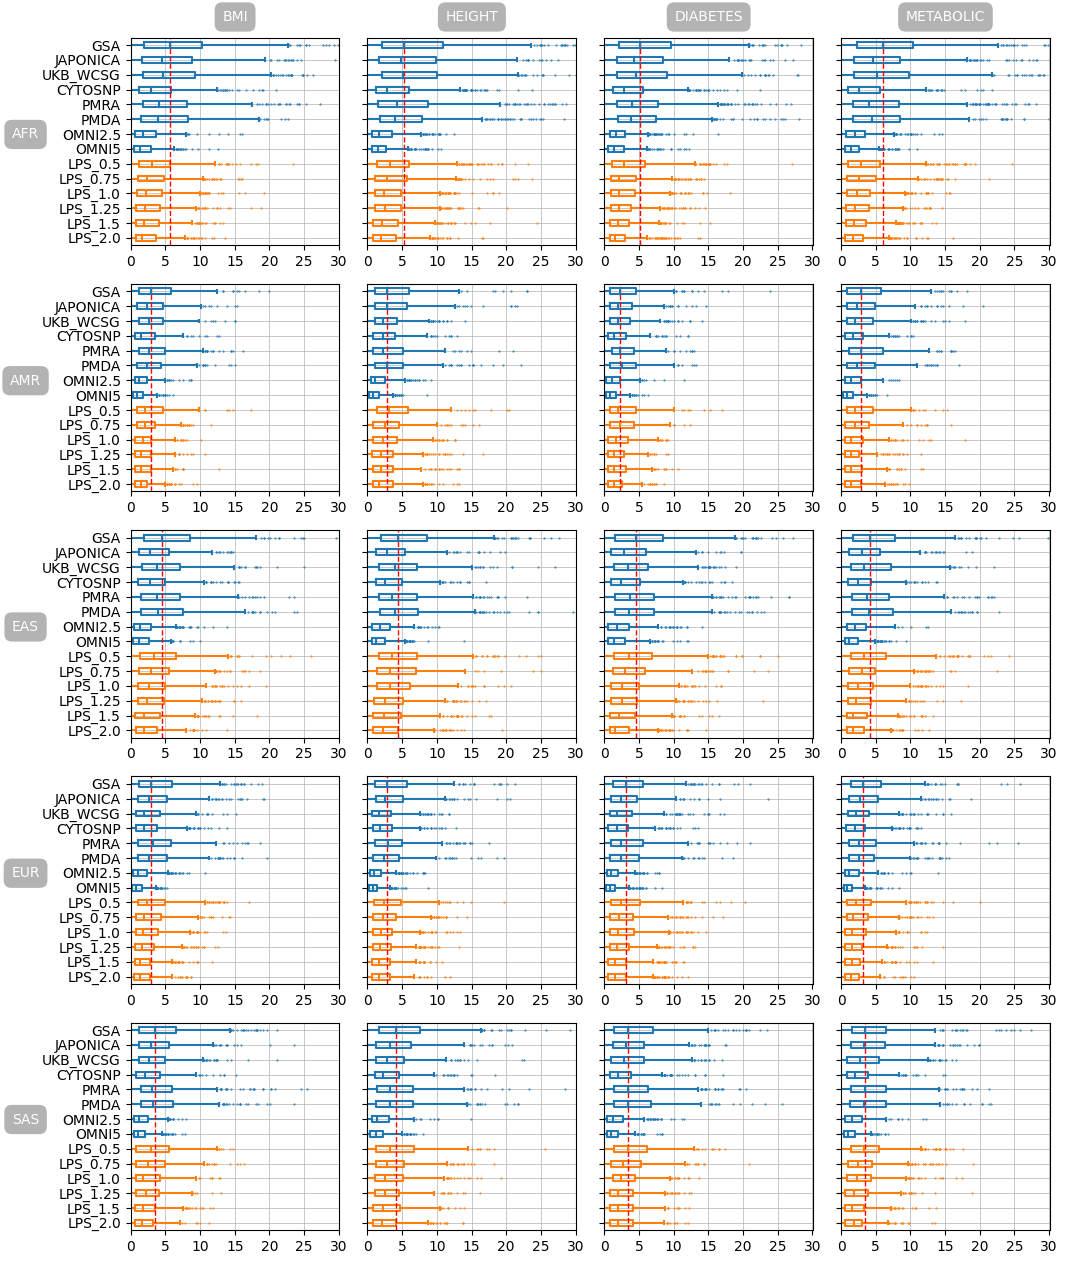

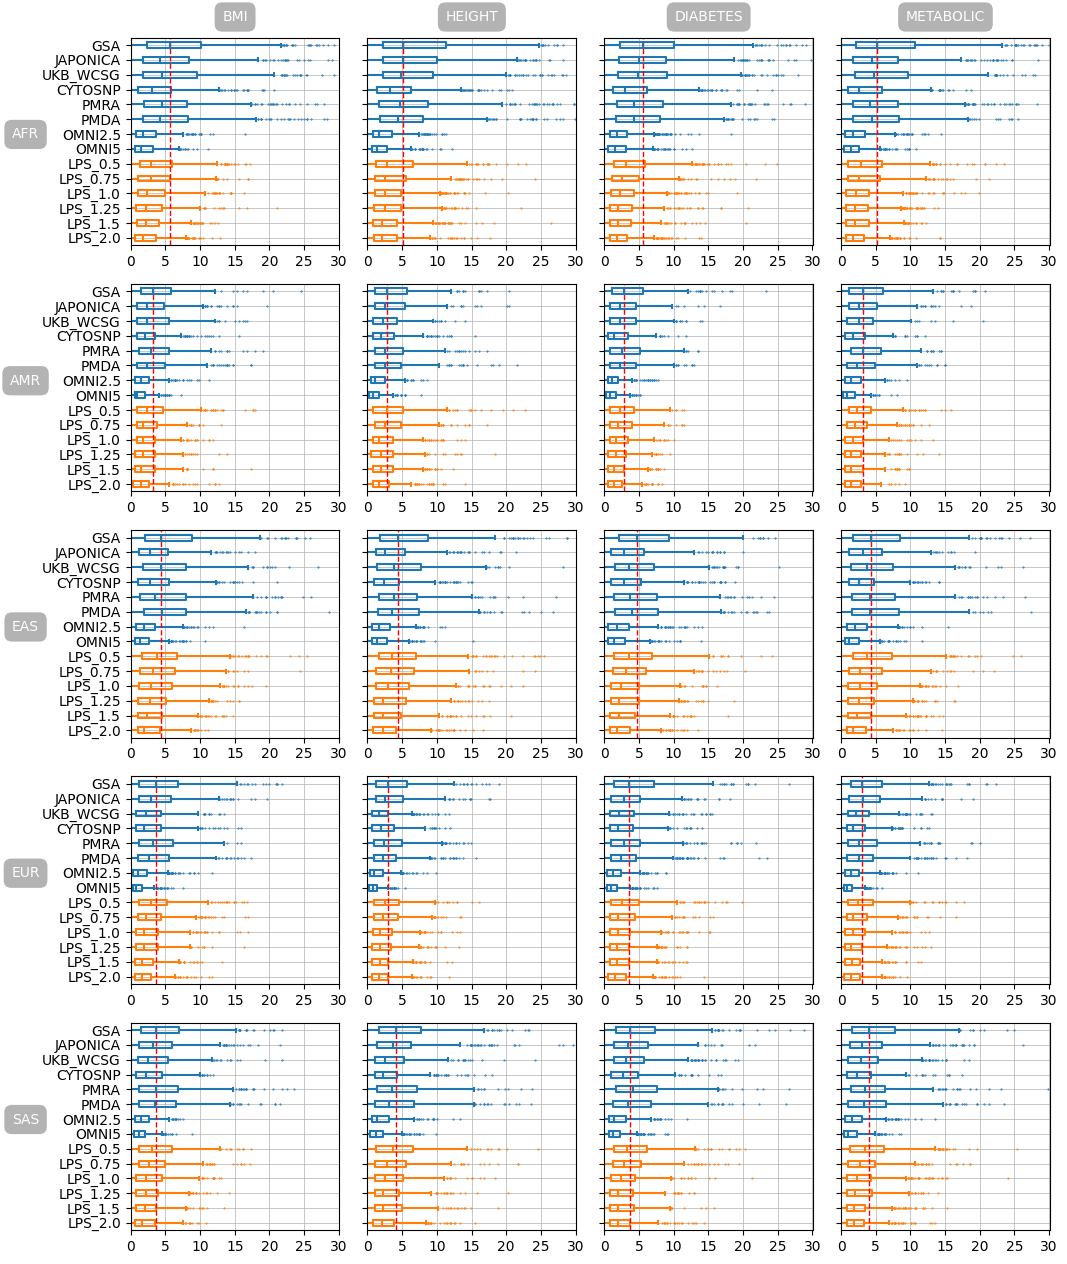

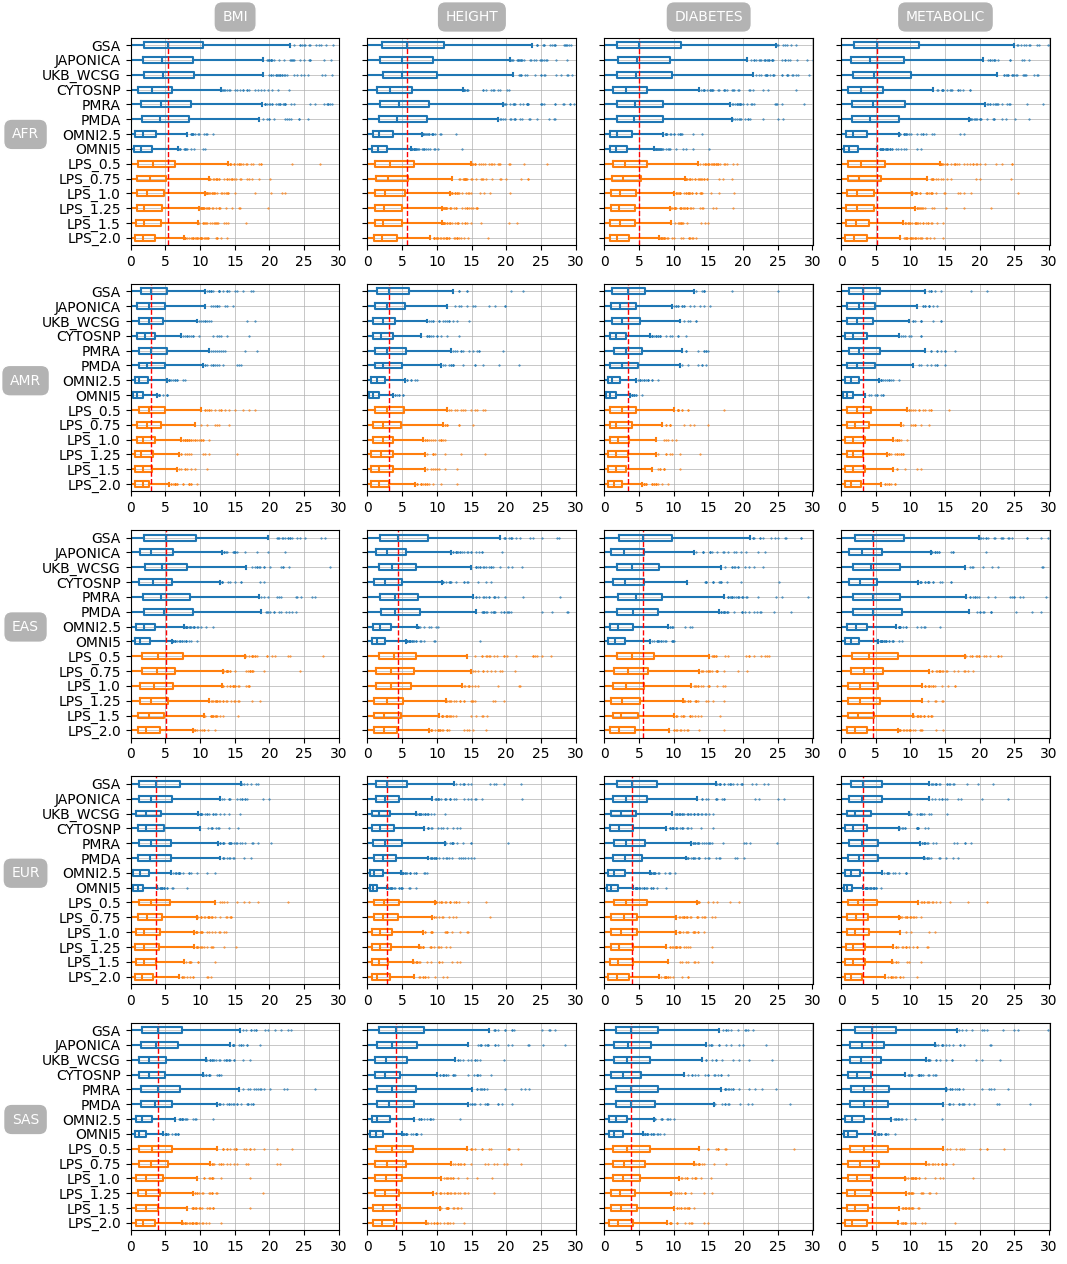

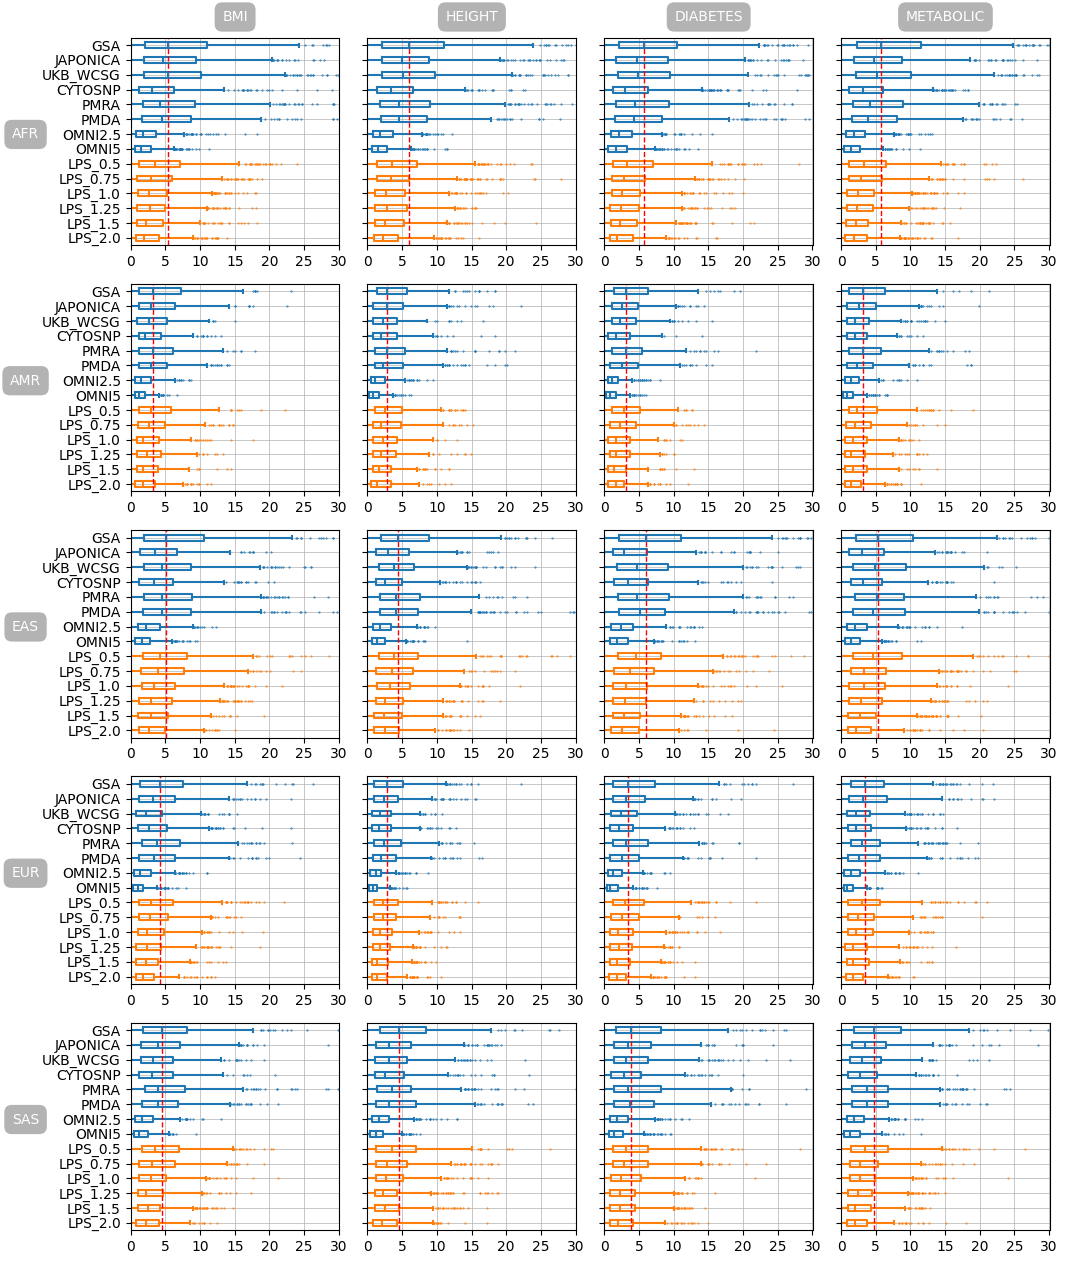

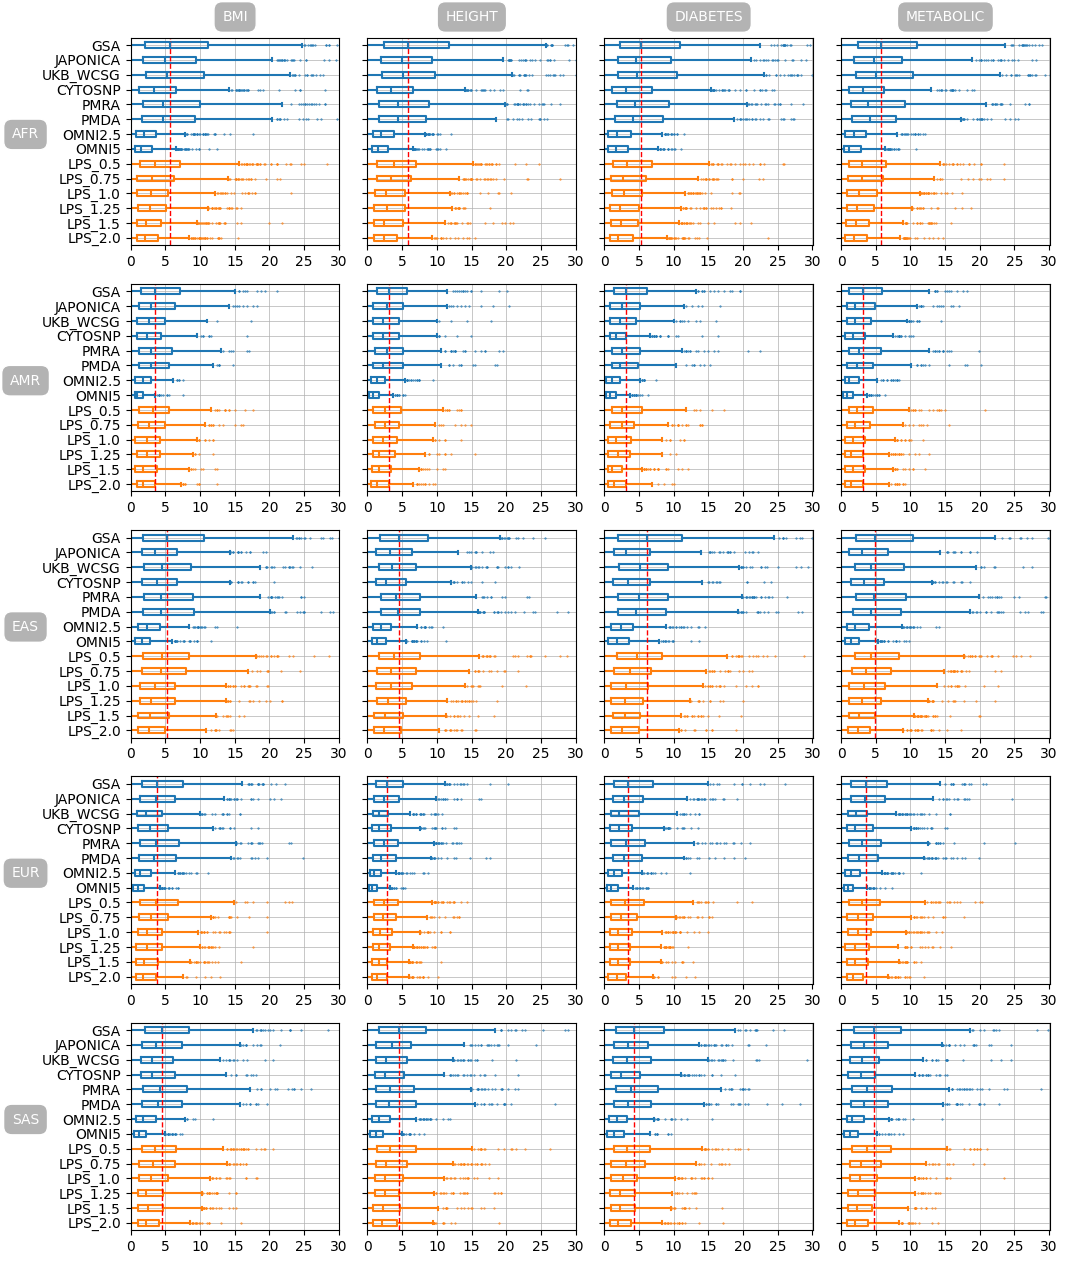

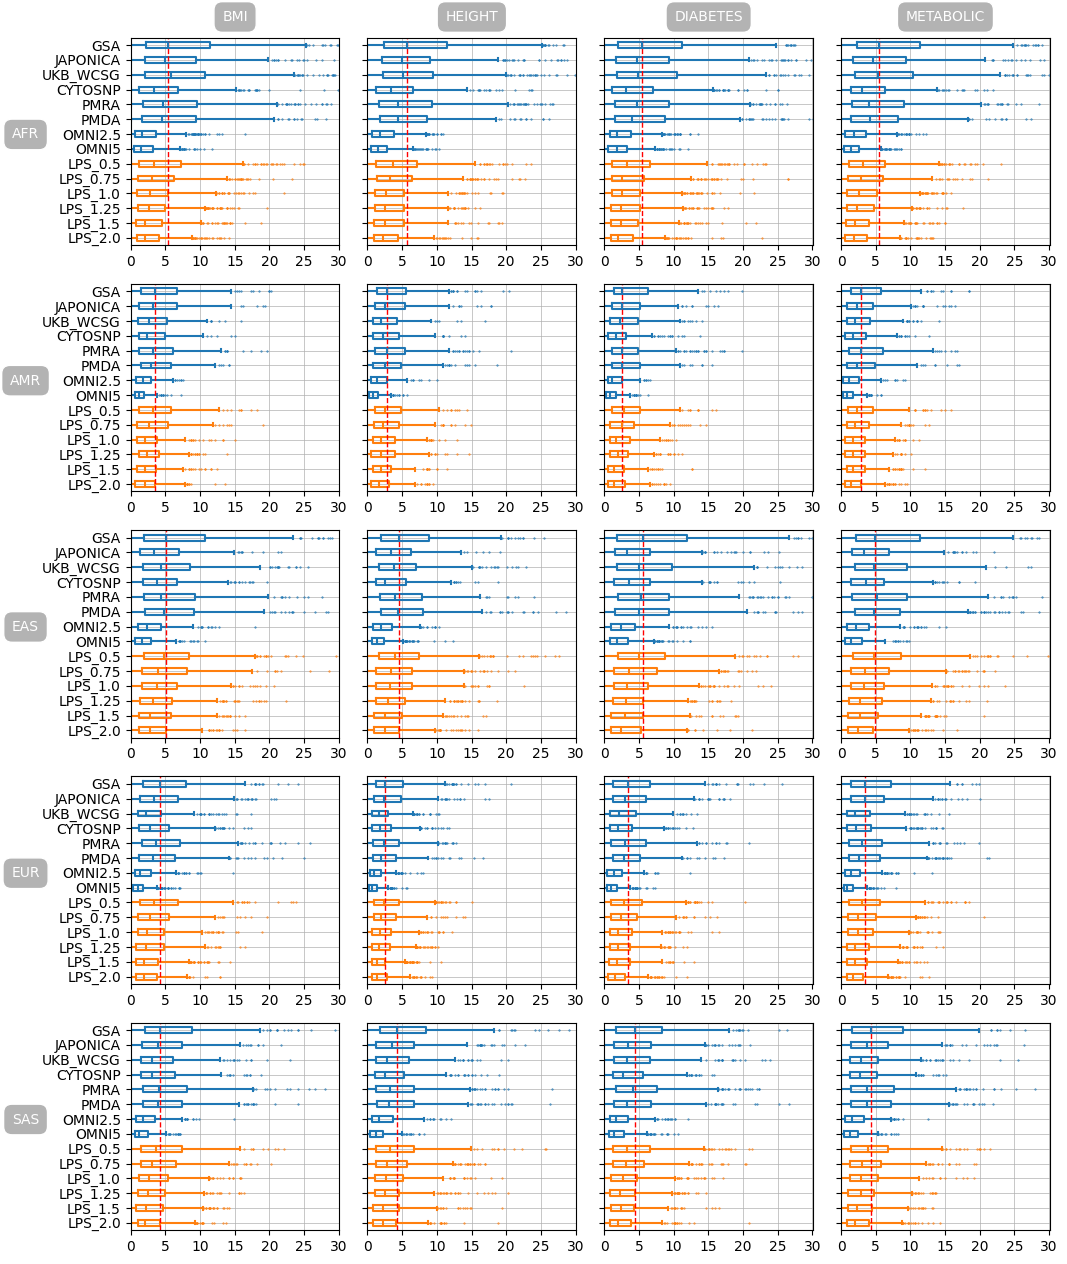

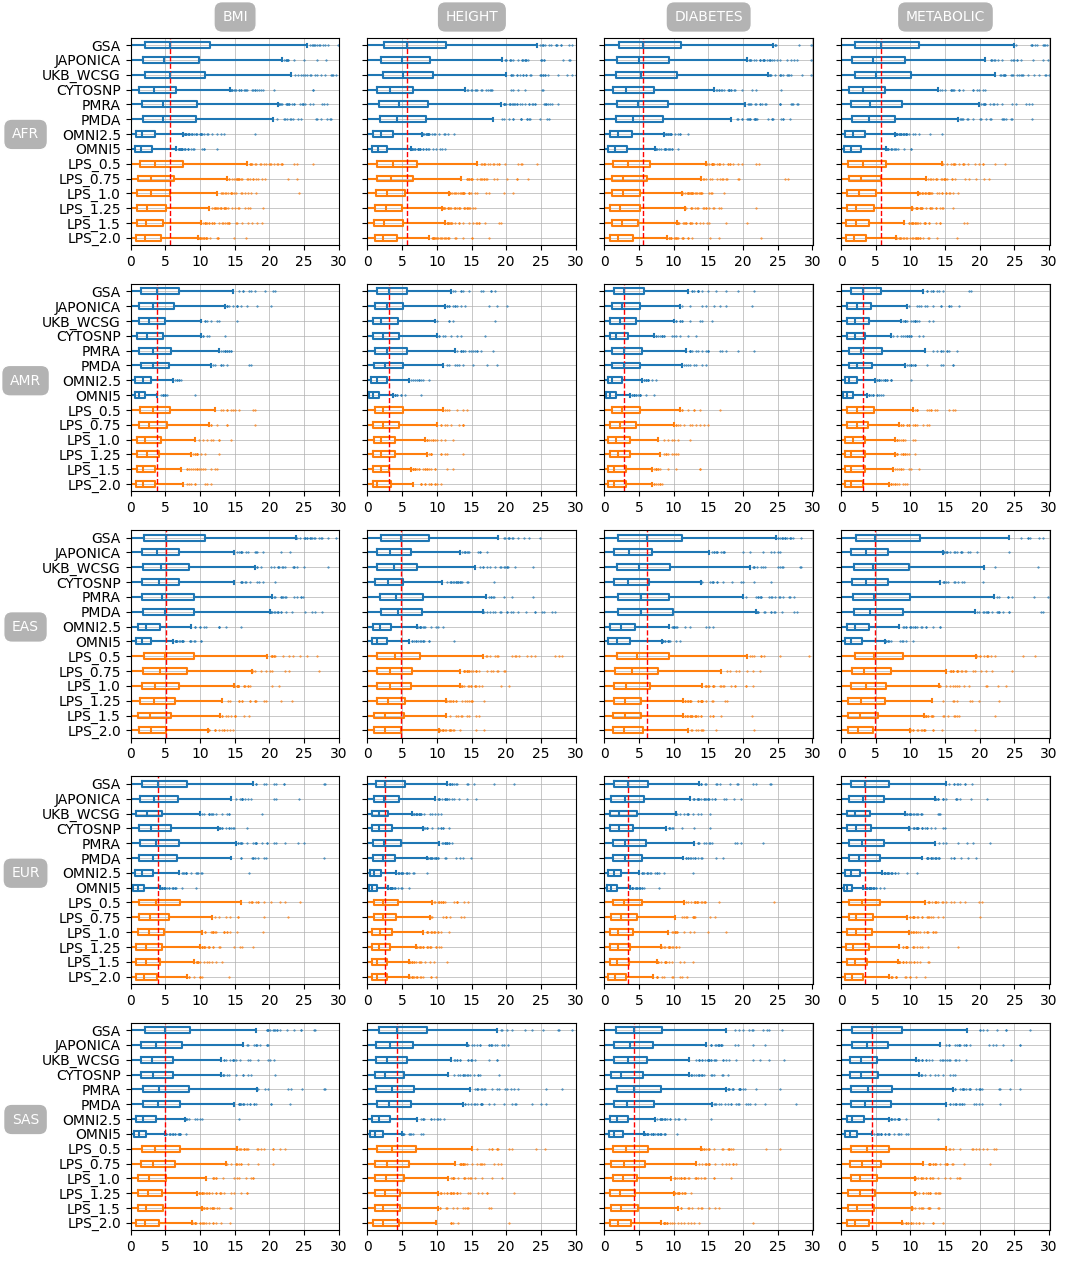

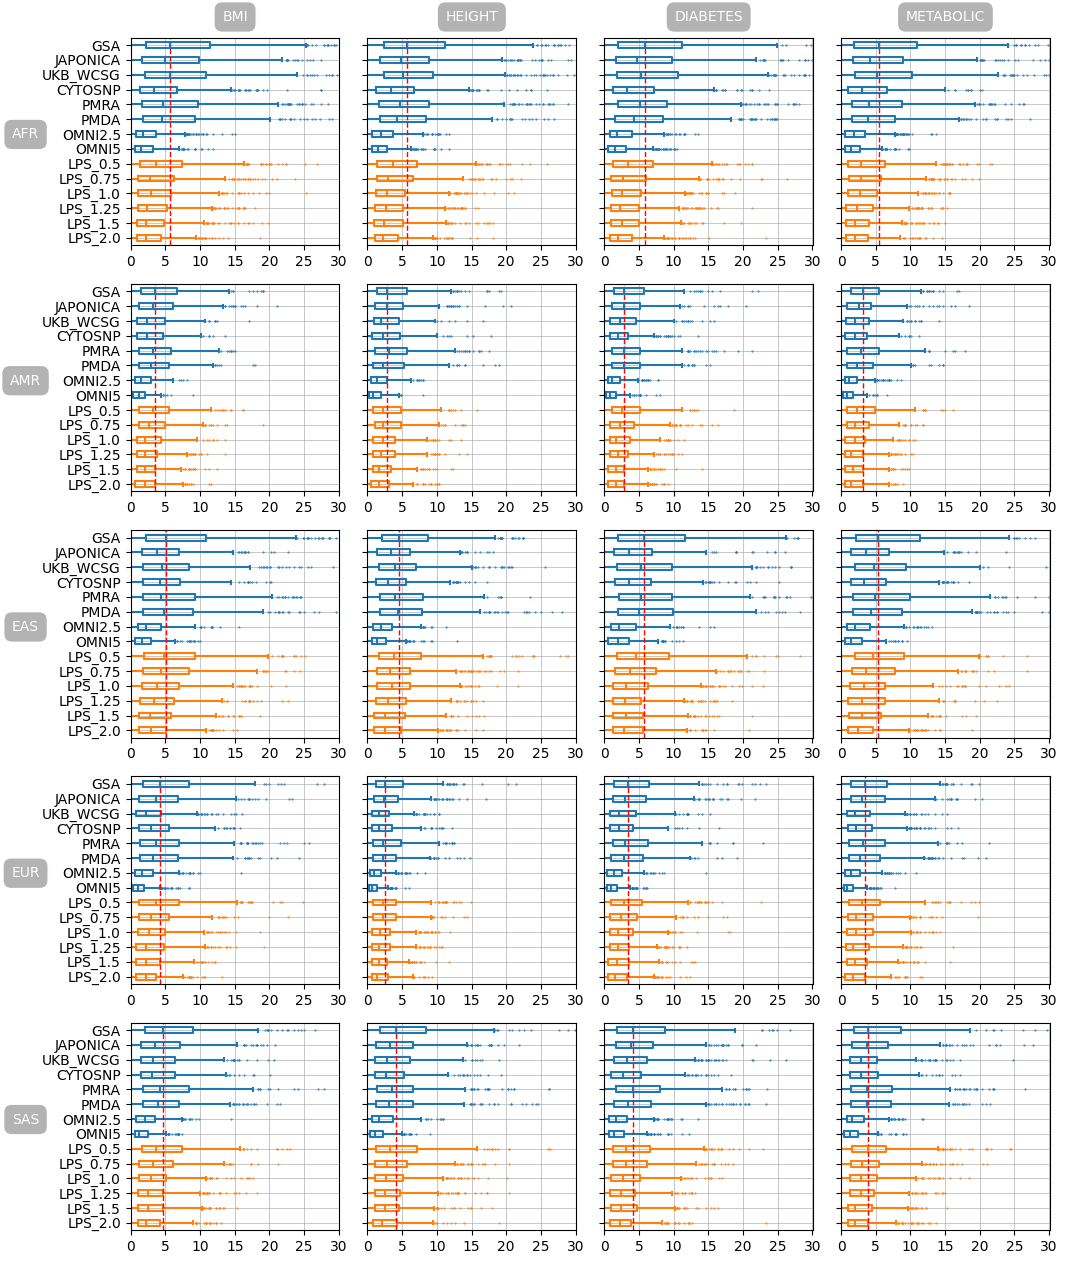

In [9]:
## i for number of table
i = 11
for cutoff in all_cutoffs:
    print(f'plotting {cutoff}')
    df = full_plot(cutoff)
    summary = df.groupby(["type", "trait", "array", "pop"]).agg(
        mean=("pct_dif", "mean"),
        std=("pct_dif", "std")
    ).reset_index()
    
    # Format output
    summary["formatted"] = summary.apply(lambda x: f"{x['mean']:.3f} ± {x['std']:.3f}", axis=1)
    
    # Pivot to table format
    result = summary.pivot(index=["trait", "array"], columns="pop", values="formatted").reset_index()
    
    # Sort by provided order
    result["array"] = pd.Categorical(result["array"], categories=desired_order, ordered=True)
    result = result.sort_values(["trait", "array"])
    result.to_csv(f"{output_table_folder}/prs_ADPR_{cutoff}.csv", index=False)
    i = i + 1

<div class="admonition output">
    <p class="admonition-title">Outputs</p>
    <ul>
        <li><a href="https://github.com/KTest-VN/lps_paper/blob/main/evaluation/downstream/out_tables/prs_percentile">PGS ADPR tables</li>
        <li><a href="https://github.com/KTest-VN/lps_paper/blob/main/evaluation/downstream/out_figs/prs_ADPR">PGS ADPR plots</li>
    </ul>
</div>